In [154]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from qiskit_machine_learning.datasets import ad_hoc_data
import numpy as np
from itertools import chain, combinations




In [155]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

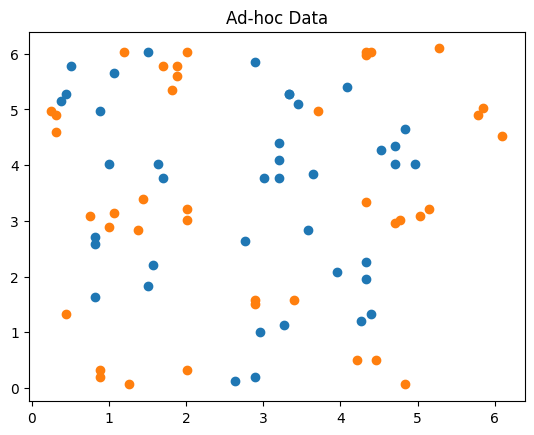

In [156]:
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=40,
    test_size=40,
    n=2,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)
train_labels = np.where(train_labels == 0, -1, 1)
test_labels = np.where(test_labels == 0, -1, 1)

#print("Training labels" + str(train_labels))
#print("Test labels" + str(test_labels))
#print("Size of training data" + str(train_features.shape) + " " + str(train_labels.shape))
#print("Size of test data" + str(test_features.shape) + " " + str(test_labels.shape))


In [157]:
dev = qml.device("default.qubit", wires=2, shots=1000)

In [158]:
def powerset(iterable, size):
    s = list(range(len(iterable)))
    return chain.from_iterable(combinations(s, r) for r in range(size + 1))

In [159]:
def variational_layer(W):

    for wire in range(2):
        qml.Rot(1, W[wire],0, wires=wire)

    for wires in ([0, 1], [1, 0]):
        qml.CNOT(wires)

In [160]:
def state_preparation(x, reps = 2):
    list_of_set = list(powerset(x, 2))

    for _ in range(reps):
        for i in range(len(x)):
            qml.Hadamard(i)
        for l in list_of_set:
            if len(l) == 0:
                continue
            if len(l) == 1:
                qml.PhaseShift(-2 * x[l[0]], l[0])
            else:
                (i, j) = l
                qml.CNOT(i, j)
                qml.PhaseShift(-2 *(np.pi-x[i])*(np.pi-x[j]), j)
                qml.CNOT(i, j)
        qml.barrier()

In [161]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    print (weights)

    for W in weights:
        variational_layer(W)

    return qml.expval(qml.PauliZ(0))

In [162]:
def variational_classifier(var, bias, x):
    return circuit(var, x) + bias

In [163]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [164]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [165]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [166]:
np.random.seed(0)
num_qubits = 2
num_layers = 1
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 2)
bias_init = np.array(0.0)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[0.01764052 0.00400157]
  [0.00978738 0.02240893]]]
Bias:  0.0


In [167]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [168]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(train_features), (batch_size,))
    X_batch = train_features[batch_index]
    Y_batch = train_labels[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in train_features]

    current_cost = cost(weights, bias, train_features, train_labels)
    acc = accuracy(train_labels, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

c:\Users\march\anaconda3\envs\bach\Lib\site-packages\pennylane\_grad.py:157: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


TypeError: cannot unpack non-iterable int object